 # Image Classification by Support Vector Machines

### 1. Tensor Data (Tensor)
Tensors can be understood as a generalization of matrices:

- Zero-dimensional tensor (0D tensor): Also called a scalar, it is just a number. For example: 5

- One-dimensional tensor (1D tensor): Also called a vector, it consists of a series of numbers. For example: [1, 2, 3, 4]

- Two-dimensional tensor (2D tensor): Also called a matrix, it is a 2D grid composed of numbers. For example:

[[1, 2, 3],
[4, 5, 6],
[7, 8, 9]]

- Three-dimensional tensor (3D tensor): A three-dimensional tensor can be seen as a numeric cube, made up of multiple two-dimensional matrices (2D tensors) stacked together. It has three dimensions: typically understood as height, width, and depth. For example, stacking two 3x3 matrices:
- First layer:
[[1, 2, 3],
[4, 5, 6],
[7, 8, 9]]

- Second layer:
[[10, 11, 12],
[13, 14, 15],
[16, 17, 18]]
results in a 3x3x2 three-dimensional tensor.

### 2. Applications of 3D Tensor Data
Common applications of 3D tensors include:

- Image data: A color image is usually composed of three color channels (red, green, blue), and thus can be represented as a 3D tensor. For example, a 256x256 color image can be represented as a 3D tensor of shape [256, 256, 3].

- Financial market time series data: For example, a day's stock price information includes [opening price, closing price, highest price, lowest price, volume]. If there are 100 stocks, a day's stock information is a 100x5 matrix, and a time series is such a matrix stacked over time.

### Data of this exercise

- Images in 21 categories (in TIFF file format), each category containing 100 images. Our goal is to predict the category of an image based on its information.

- The images are color images, so we need to convert each image into a 3D tensor, width x height x channel.

- All images are stored in one folder (Images).

- The folder contains 21 subfolders, each representing one of the 21 categories, with each subfolder containing 100 images belonging to that category.

In [10]:
!pip install tensorly

In [ ]:
!pip install 

###  Read images from each folder and convert each image into a 64x64x3 tensor

In [13]:
import os
import cv2
from PIL import Image
import numpy as np    
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data = []
labels = []
import os
for dirname, _, images in os.walk('/kaggle/input/land-use/UCMerced_LandUse/Images'):
    for image in images:
        try:
            im = Image.open(os.path.join(dirname, image))
            im = im.resize((128,128))
            im = np.array(im)
            data.append(im)
            labels.append(os.path.basename(dirname))
        except Exception as e:
            print(e)
data = np.array(data)
# Normalize the pixel values
data = data.astype('float32')/256.0

labels_dict = {k: v for v, k in enumerate(set(labels))}
y = np.array([labels_dict[k] for k in labels]) # target variable

- The image tensor contains the values of each pixel encoded in the image.

- image.resize((128, 128)) resizes the image to a width of 128 pixels and a height of 128 pixels. The choice of 128 is arbitrary, mainly considering computational efficiency. If the original images are very large, resizing them to a smaller size like 128x128 can significantly speed up processing, training, or inference.

- data.astype('float32'): This converts the data type of the data array (usually representing image pixel values) to float32. Image data is typically stored as integers (ranging from 0 to 255 for 8-bit images), so this conversion ensures that subsequent division operations produce floating-point values.

- /255.0: The range of pixel values for standard RGB or grayscale images is between 0 to 255. Dividing by 255 scales these values to the [0, 1] range. This kind of normalization is commonly used in image processing, especially when using neural networks, as it can help the model converge faster and achieve better performance.

- After executing this code, the data array will contain normalized pixel values in the [0, 1] range, equivalent to normalizing the image data.

In [12]:
print('The size of image data：', data.shape)
print('The Classes of first 10 iamges:', labels[0:10])
print('The class labels', labels_dict)

The size of image data： (2100, 128, 128, 3)
The Classes of first 10 iamges: ['airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane']
The class labels {'tenniscourt': 0, 'buildings': 1, 'chaparral': 2, 'river': 3, 'harbor': 4, 'sparseresidential': 5, 'denseresidential': 6, 'mobilehomepark': 7, 'freeway': 8, 'forest': 9, 'intersection': 10, 'agricultural': 11, 'beach': 12, 'runway': 13, 'mediumresidential': 14, 'parkinglot': 15, 'overpass': 16, 'storagetanks': 17, 'airplane': 18, 'baseballdiamond': 19, 'golfcourse': 20}


- After converting to tensor data, the dimension of our feature data is (2100, 128, 128, 3), which means there are 2100 images, with each image corresponding to a 128x128x3 tensor. 

- "labels_dict" is our encoding information for the 21 categories (1-21).

#### We use the following code to randomly select 15 samples from the tensor data to plot.

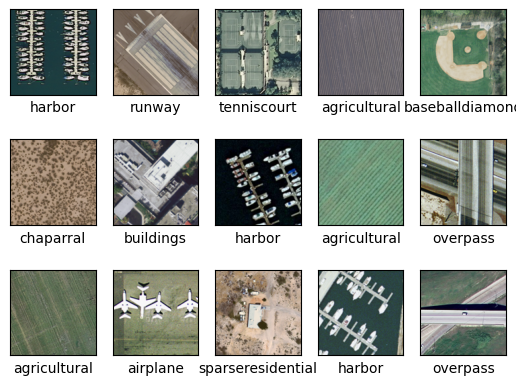

In [15]:
import matplotlib.pyplot as plt
def plot_images(data):
    indices = np.random.choice(data.shape[0], 15, replace=False)
    fig, ax = plt.subplots(3, 5)
    for i, axi in enumerate(ax.flat):
        axi.imshow(data[indices[i]], cmap='bone')
        axi.set(xticks=[], yticks=[],
                xlabel=labels[indices[i]])

plot_images(data) 

The text below each image indicates the category of that image. The plots show that the data size of 128x128x3 is able to preserve the data information well.

### Modeling Image Data

- The format of image data in tensor form differs from the data format typically used in modeling and analysis, where feature variables are a one-dimensional vector.

- In modeling and analysis, the traditional way of handling tensor data is to vectorize or flatten the data. For our data, a 128x128x3 image tensor can be converted into a (128x128x3, 1) vector.

- A potential issue with flattening is the loss of the tensor data's spatial structural information. Convolutional methods used in deep learning for processing image data can avoid this problem, which we will learn about in future big data courses.

### Dimensionality Reduction of Image Data

- The data dimension of 128x128x3 is too large for modeling and analysis, requiring dimensionality reduction before modeling.

- One method for compressing tensor data is Tucker Decomposition, which compresses a tensor into a smaller dimension tensor. (Citation: Ledyard R. Tucker, "Some mathematical notes on three-mode factor analysis", Psychometrika. 31 (3): 279–311.)

- Our data is a (2100,128,128,3) tensor. In Tucker decomposition, we decompose the data into a tensor of dimensions ($r_1$, $r_2$, $r_3$, $r_4$). The first dimension $r_1$ corresponds to the number of samples and should not be compressed. The fourth dimension $r_4$ represents the image color channels, with color images having three channels: red, green, and blue, which generally should not be compressed either, as compression would lead to the loss of color information. Therefore, Tucker decomposition in this case mainly compresses the width and height of the image, corresponding to the second and third dimensions.

- Another method for compression is to apply compression after vectorizing the data, using Principal Component Analysis (PCA), a technique we have learned about previously.

##### Tucker Decomposition
- In the example below, we use Tucker decomposition to compress each image from a 128x128x3 tensor to a 15x15x3 tensor. 

In [5]:
import tensorly as tl
from tensorly.decomposition import tucker

decomposition = tucker(data, rank=[2100, 15, 15, 3])

core = decomposition.core
factors = decomposition.factors



- In the above code, core is our compressed tensor data. factors are the ranks of the original data in four dimensions, through which the image can be reconstructed from the compressed data.

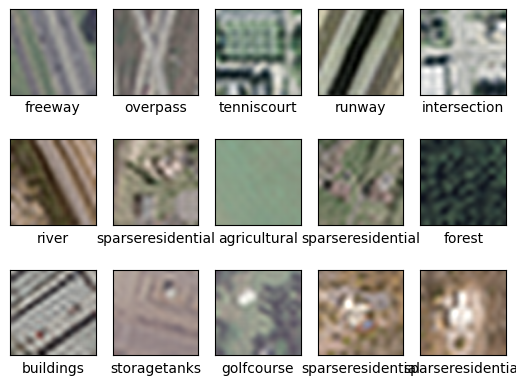

In [6]:
reconstructed_images = tl.tucker_to_tensor((core, factors))
plot_images(reconstructed_images)
reduced_data_Tucker = core.reshape((core.shape[0], -1))

- After data compression, the loss in image precision is significant.

### Compress the vectorized data using PCA (Principal Component Analysis).



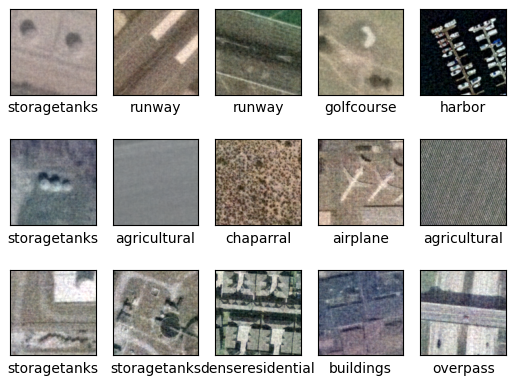

In [18]:
from sklearn.decomposition import PCA

# Reshape the tensor data into a 2D matrix: each row is a flattened image
matrix_data = data.reshape((data.shape[0], -1))

# Apply PCA to reduce dimensionality 
pca = PCA(n_components=750)  
reduced_data_PCA = pca.fit_transform(matrix_data)

# Optional: Inverse transform and reshape to visualize the PCA-transformed images
approximated_data = pca.inverse_transform(reduced_data_PCA)
approximated_images = approximated_data.reshape(data.shape)
plot_images(approximated_images)

- Using PCA on the vectorized data, we compress the data source to 675 dimensions. The resulting images have better precision compared to those from the previous Tucker decomposition. 

### Classify images using Support Vector Machine on the compressed data.

- In the above code, we compressed the image data using two methods. Next, we will use these two sets of compressed data to classify the images separately.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
Xtrain_PCA, Xtest_PCA, ytrain, ytest = train_test_split(reduced_data_PCA, y,random_state=42)
#scalar = StandardScaler()
#Xtrain_PCA = scalar.fit_transform(Xtrain_PCA)
#Xtest_PCA = scalar.fit_transform(Xtest_PCA)
#Xtrain_Tucker, Xtest_Tucker, ytrain, ytest = train_test_split(reduced_data_Tucker, y,random_state=42)

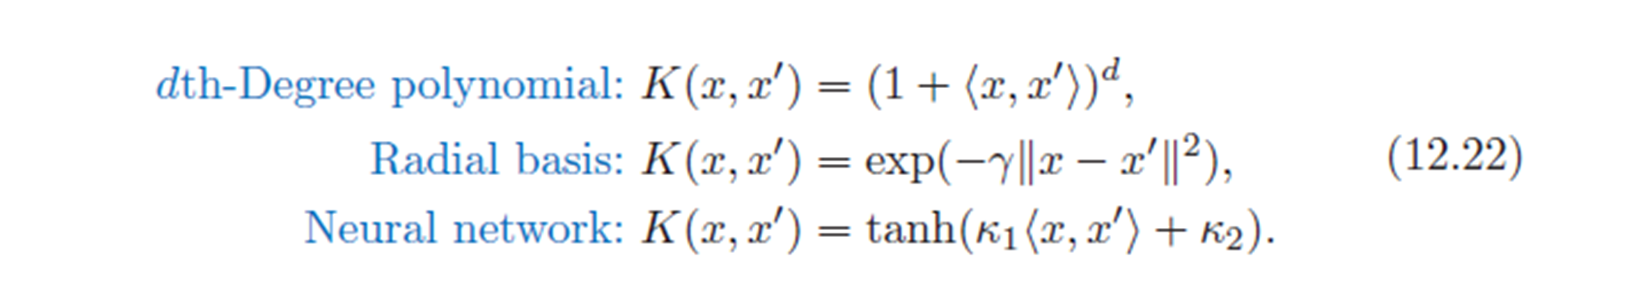##### Support Vector Machine Hyperparameter Tuning

- Hyperparameters include: the kernel function and the parameters corresponding to each kernel function.

- Tuning method: Multiple cross-validation.

- Python's SVC built-in kernel function options: kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’.

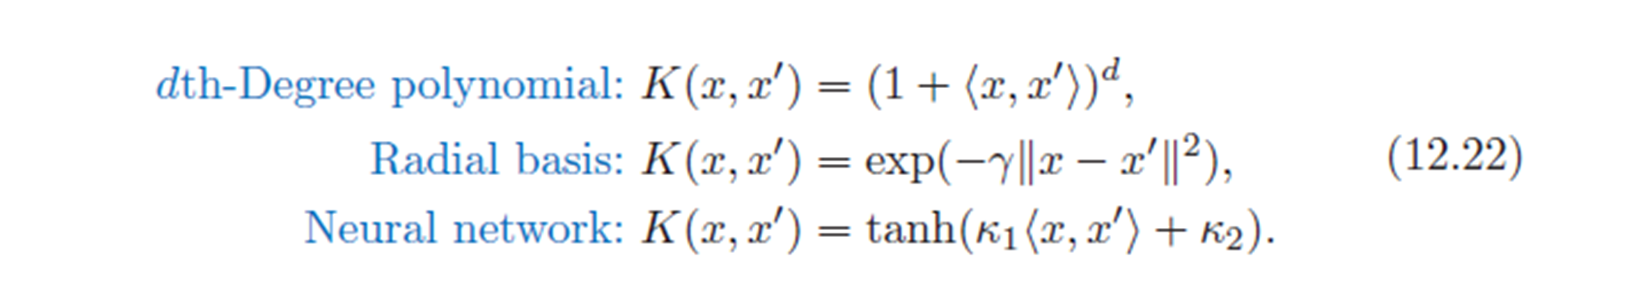

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid={'gamma':[0.0001,0.001,0.1,1],'coef0':[0.0001, 0.005, 0.01, 0.05, 1], 'kernel':['rbf', 'poly','sigmoid']}
model = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
model.fit(Xtrain_PCA, ytrain)
print(model.best_params_)

{'coef0': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


- In the above code, gamma and coef0 correspond to the hyperparameters of the kernel function in formula (12.22). Sigmoid or Neural Network have two hyperparameters. Next, we use the obtained optimal hyperparameter values to classify images through SVM.

In [20]:
from sklearn.metrics import accuracy_score
svc = SVC(kernel='rbf', class_weight='balanced', gamma=0.001)
svc.fit(Xtrain_PCA, ytrain)
yfit = svc.predict(Xtest_PCA)
# Compute the accuracy
accuracy = accuracy_score(ytest, yfit)
print("Accuracy:", accuracy)


Accuracy: 0.41333333333333333


- The model accuracy is 0.415, meaning that if we use this model to classify new images (images outside of the training set), the rate of correct classification is about 42%. The accuracy of random classification without a model is 1/21.

- We can evaluate the model's classification performance more carefully using a Confusion Matrix.

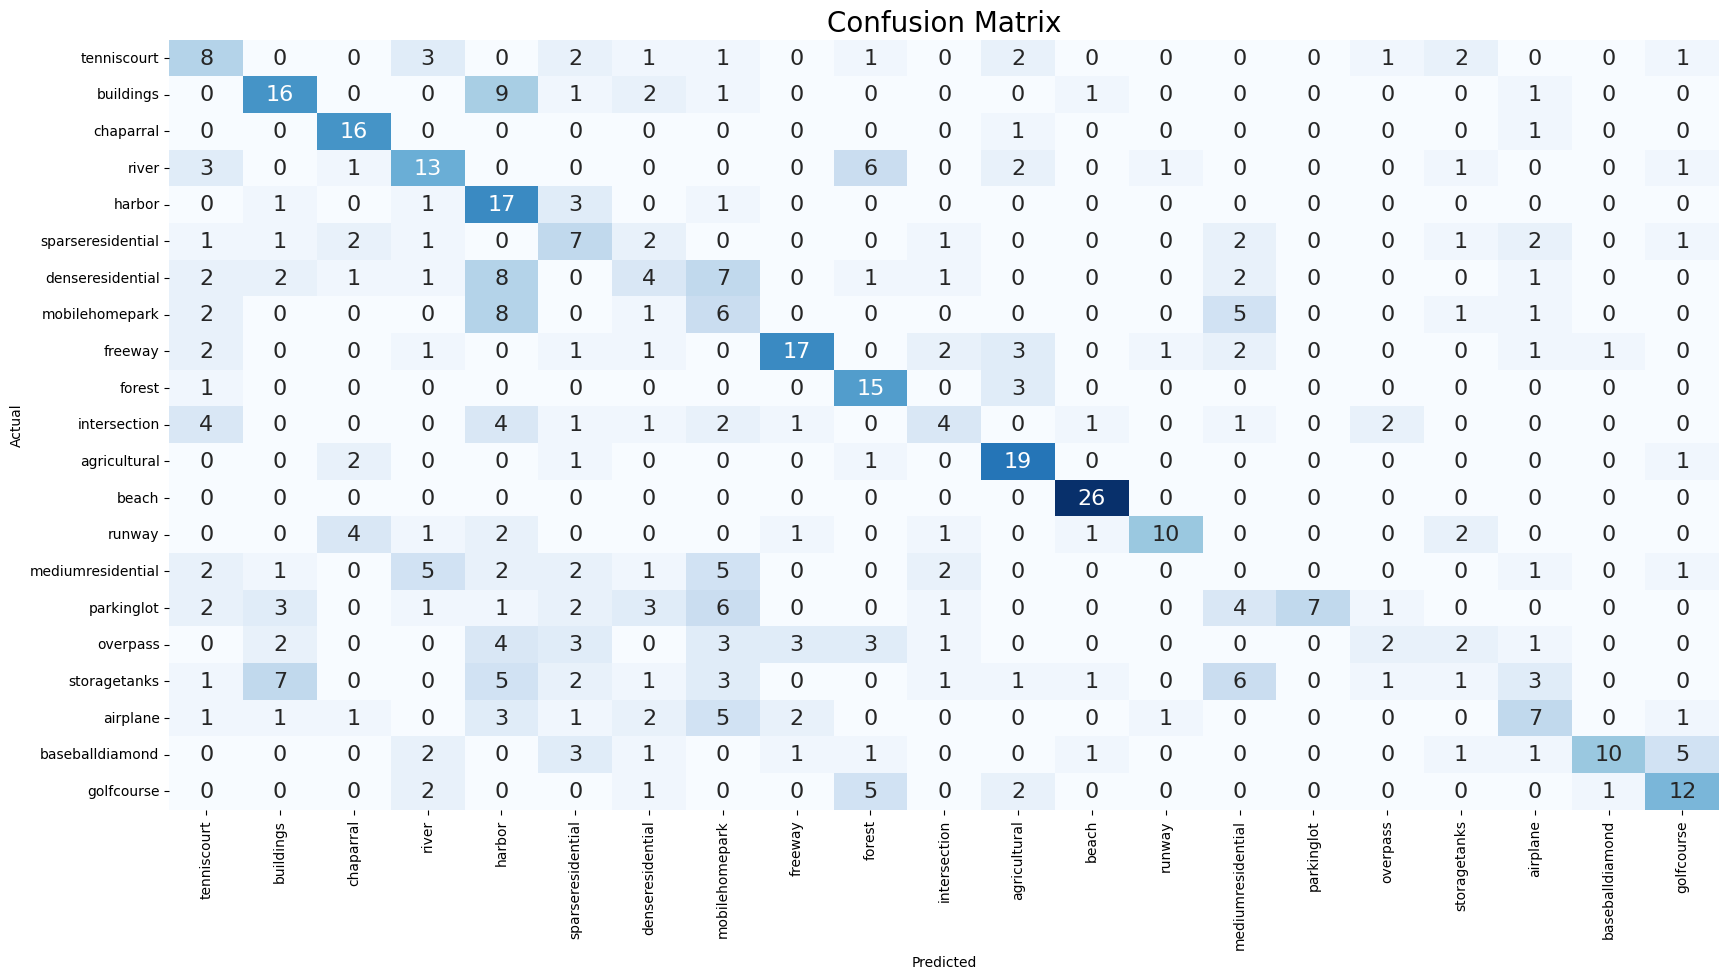

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_data = confusion_matrix(ytest , yfit)
cm = pd.DataFrame(cm_data, columns=labels_dict.keys(), index = labels_dict.keys())
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

- As an exercise, everyone can calculate the precision and recall rates for each category using the Confusion Matrix. It can be generally observed that the model performs well in classifying certain categories like "beach" and "baseball field". For some categories like "parking", the recall rate is relatively high.